Example notebook showing how to use the MCMC sampler (currently in development)

In [1]:
import os
import sys
import torch
from getdist import plots, MCSamples
import getdist
import numpy as np
import matplotlib.pyplot as plt
import emcee
import logging

In [2]:
path = os.path.realpath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, path)

In [3]:
from nnest import MCMCSampler
from nnest.likelihoods import *
from nnest.priors import *

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
# Likelihood
#like = Himmelblau(2)
#prior = UniformPrior(2, -5, 5)
like = Rosenbrock(4)
prior = UniformPrior(4, -2, 10)
#like = Gaussian(2, 0.9)
#prior = UniformPrior(2, -5, 5)
#like = Eggbox(2)
#prior = UniformPrior(2, -15, 15)
#like = GaussianShell(2)
#prior = UniformPrior(2, -3, 3)
#like = GaussianMix(2)
#prior = UniformPrior(2, -8, 8)
#like = DoubleGaussianShell(2, centers=[[-4.0, 0.0], [4.0, 0.0]], weights=[0.5, 1.0])
#prior = UniformPrior(2, [-7, -3], [7, 3])

In [6]:
sampler = MCMCSampler(like.x_dim, like, flow='spline', prior=prior)

Creating directory for new run logs/test/run25
[nnest.trainer] [INFO] SingleSpeedSpline(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): Invertible1x1Conv()
      (2): NSF_CL(
        (f1): MLP(
          (net): Sequential(
            (0): Linear(in_features=2, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): LeakyReLU(negative_slope=0.2)
            (6): Linear(in_features=16, out_features=46, bias=True)
          )
        )
        (f2): MLP(
          (net): Sequential(
            (0): Linear(in_features=2, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_fe

[nnest.sampler] [INFO] Initial acceptance [0.1915]
[nnest.sampler] [INFO] Acceptance [0.1906] min ESS [8.5795] max ESS [26.0785] average jump [0.3943]
[nnest.trainer] [INFO] Number of training samples [200]
[nnest.trainer] [INFO] Training jitter [0.0100]
[nnest.trainer] [INFO] Epoch [1] train loss [0.0425] validation loss [0.1570]
[nnest.trainer] [INFO] Epoch [100] train loss [-0.0010] validation loss [0.0103]
[nnest.trainer] [INFO] Epoch [200] train loss [-0.0046] validation loss [0.0065]
[nnest.trainer] [INFO] Epoch [242] ran out of patience
[nnest.trainer] [INFO] Best epoch [192] validation loss [0.0040] train time (s) [12.6766]]
[nnest.sampler] [INFO] Step [100] acceptance [0.3733]
[nnest.sampler] [INFO] Acceptance [0.3690] min ESS [12.8879] max ESS [49.0944] average jump [0.3457]
Removed no burn in


IndexError: index 0 is out of bounds for axis 1 with size 0

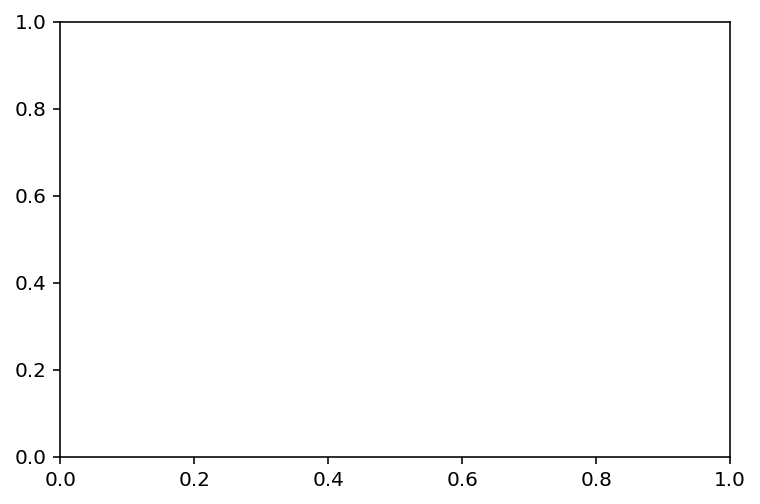

In [7]:
sampler.run(2000, 5, bootstrap_iters=3, bootstrap_num_walkers=200, bootstrap_burn_in=100)

In [ ]:
fig = plt.figure(figsize=(8,6))
for i in range(1):
    plt.plot(sampler.samples[i,:,0], sampler.samples[i,:,1])
plt.show()

In [ ]:
fig, ax = plt.subplots(like.x_dim, 1, figsize=(10, like.x_dim), sharex=True)
for i in range(like.x_dim):
    ax[i].plot(sampler.samples[0,:,i])
plt.show()

In [ ]:
mc = MCSamples(samples=[sampler.samples[i, :, :].squeeze() for i in range(sampler.samples.shape[0])], 
               loglikes=[-sampler.loglikes[i, :].squeeze() for i in range(sampler.loglikes.shape[0])], 
               ignore_rows=0.3)

In [ ]:
print(mc.getEffectiveSamples())
print(mc.getMargeStats())
print(mc.getConvergeTests())

In [ ]:
g = plots.getSubplotPlotter(width_inch=8)
g.triangle_plot(mc, filled=True)

In [ ]:
N = np.exp(np.linspace(np.log(100), np.log(sampler.samples.shape[1]), 10)).astype(int)
autocorr = np.zeros((len(N), sampler.samples.shape[2]))
logging.disable(logging.CRITICAL)
for i, n in enumerate(N):
    autocorr[i, :] = emcee.autocorr.integrated_time(np.transpose(sampler.samples[:,:n,:], axes=[1, 0, 2]), quiet=True)

In [ ]:
plt.figure(figsize=(8,6))
for i in range(autocorr.shape[1]):
    plt.loglog(N, autocorr[:, i], "o-")
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
plt.xlabel("number of samples, $N$", fontsize=14)
plt.ylabel(r"$\tau$ estimates", fontsize=14)
plt.show()